In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from sklearn.datasets import fetch_openml
from PIL import Image

### Loading and Displaying The Data

In [2]:
mnist = fetch_openml('mnist_784') # Loading MNIST data with sklearn

In [3]:
mnist_array = np.array(mnist.data) # Converting the data to a NumPy array

In [4]:
mnist_array = mnist_array.reshape((70000, 28, 28)) # Reshaping the data back into images instead of column vectors

(-0.5, 27.5, 27.5, -0.5)

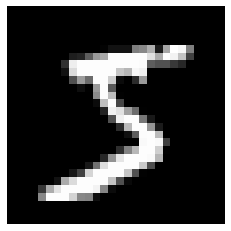

In [5]:
# Displaying the first entry in the dataset
plt.imshow(mnist_array[0,:,:], cmap='gray')
plt.axis('off')

# The Idea

The idea for this classification scheme is simple: create 10 "perfect" digit images, and for each image we want to classify, compute its similarity to each of the 10 images, and classify it according to which image it is the most similar to.

To do this, all we need to do is make the perfect digits and the comparison function.

### Creating "Ideal" Digits
I followed some of the examples in this thread to convert the figures to NumPy arrays: https://stackoverflow.com/questions/35355930/matplotlib-figure-to-image-as-a-numpy-array. Accessed 11/27/21.

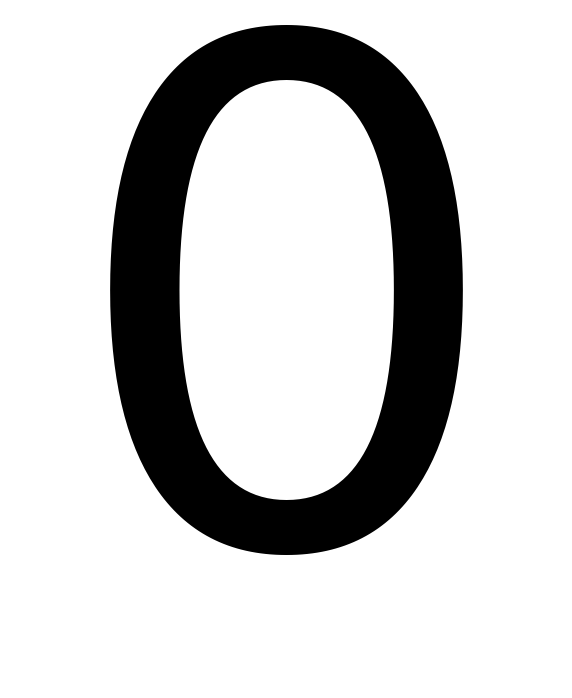

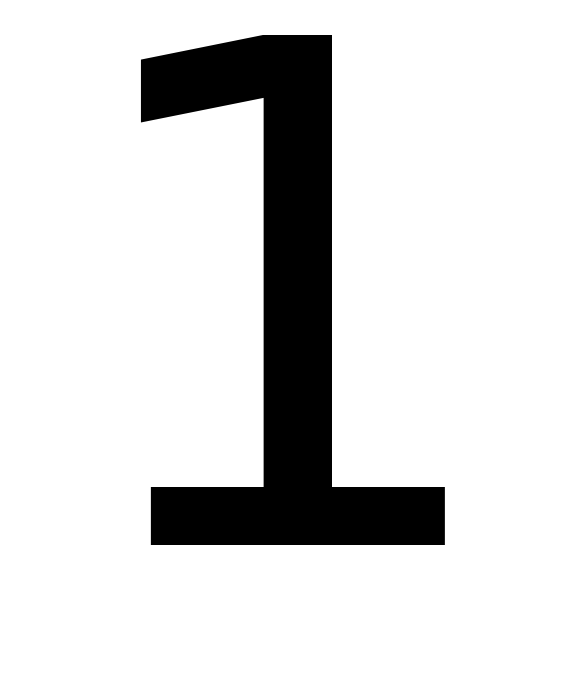

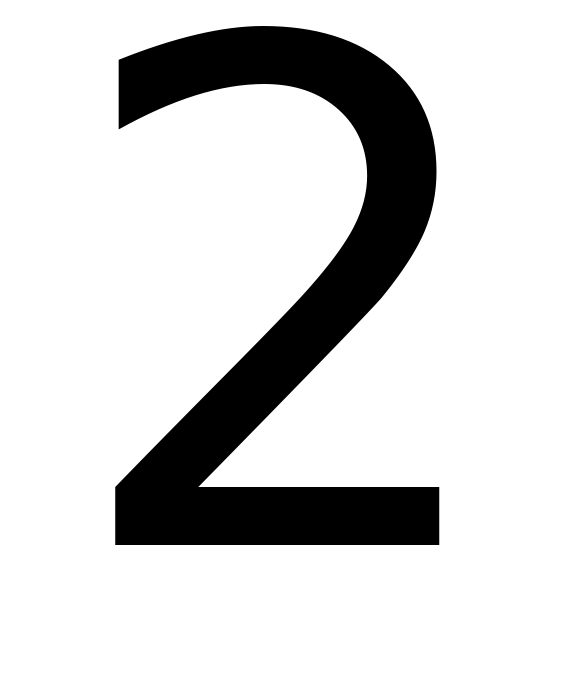

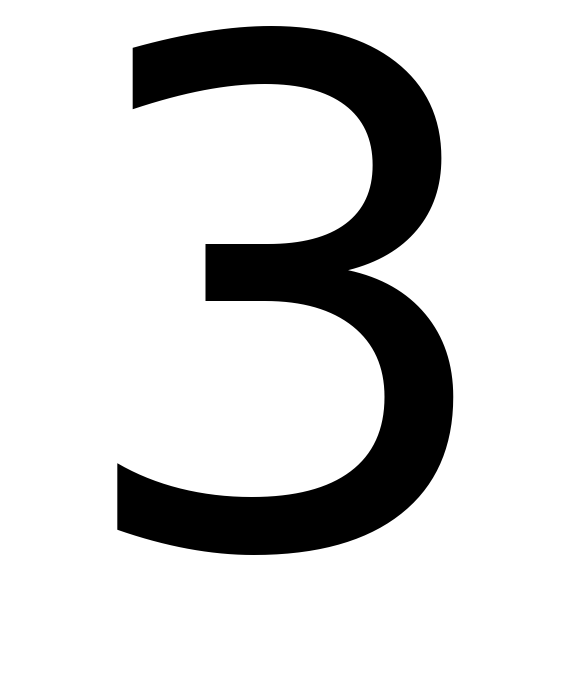

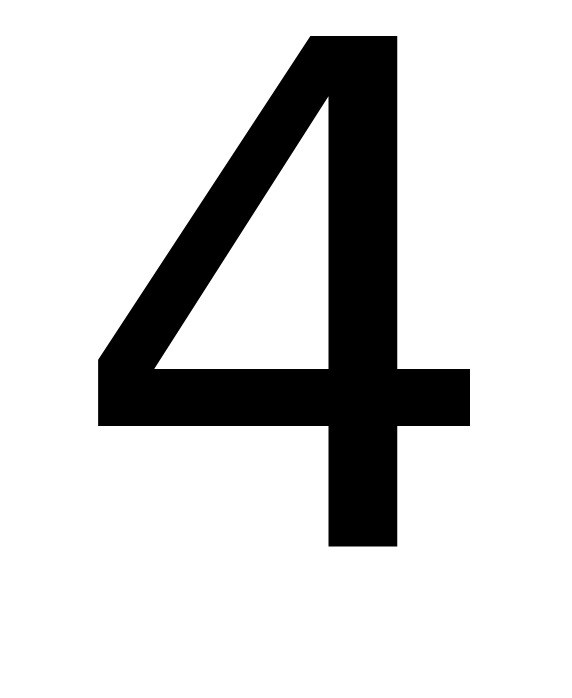

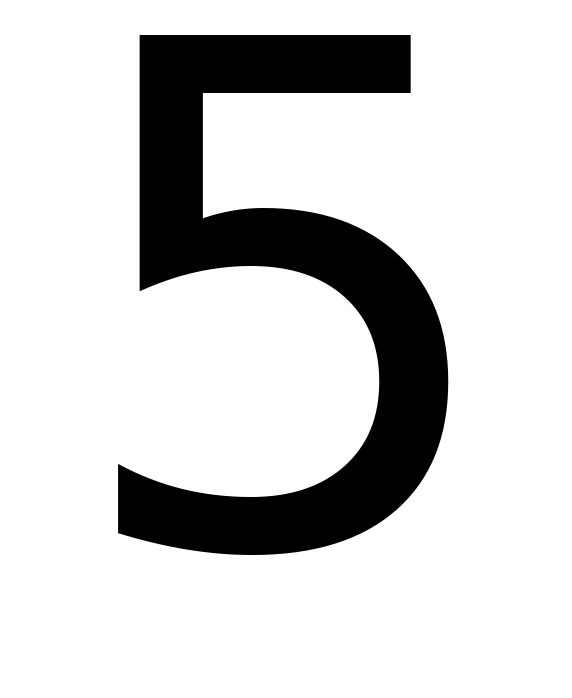

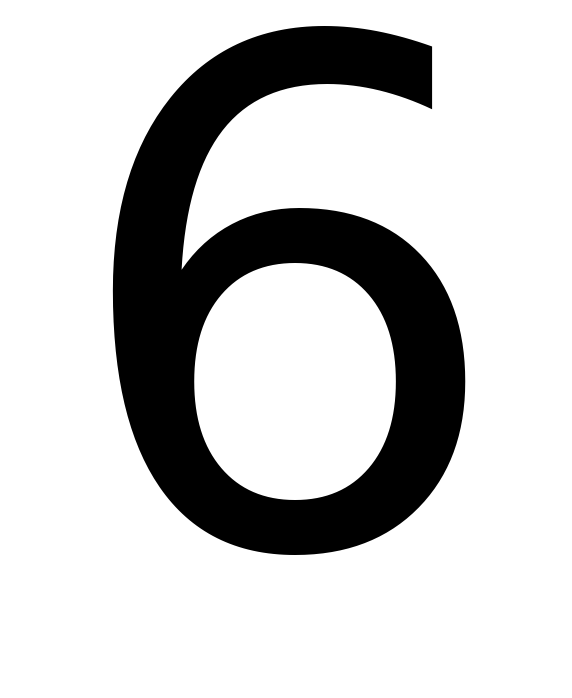

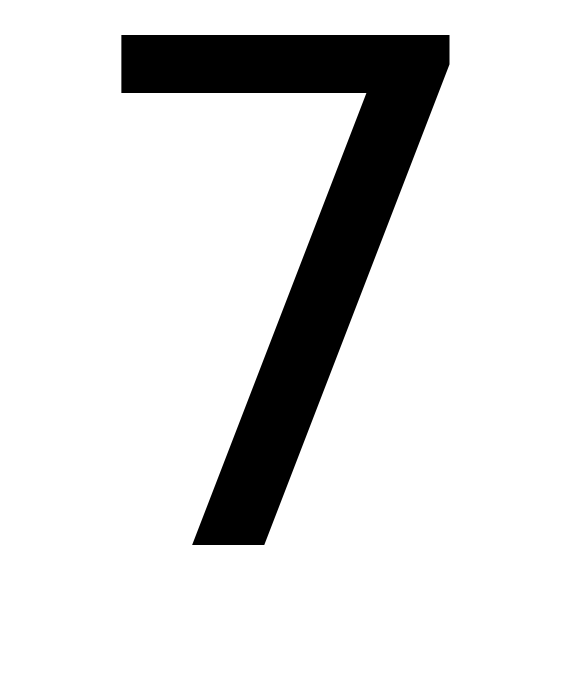

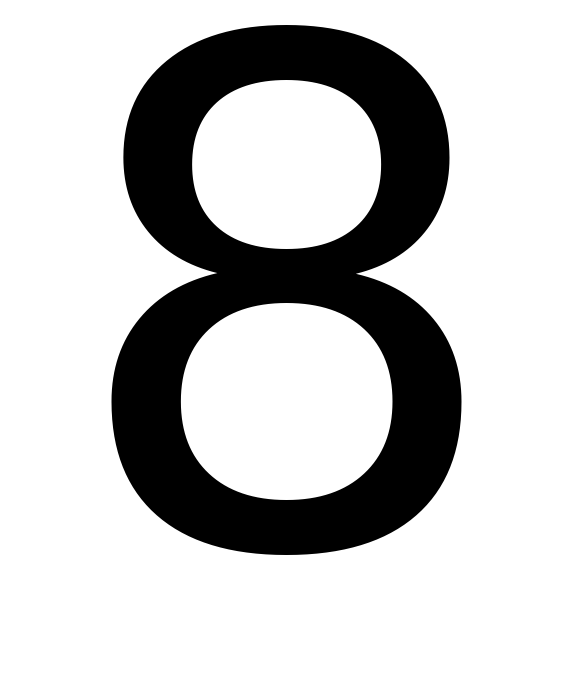

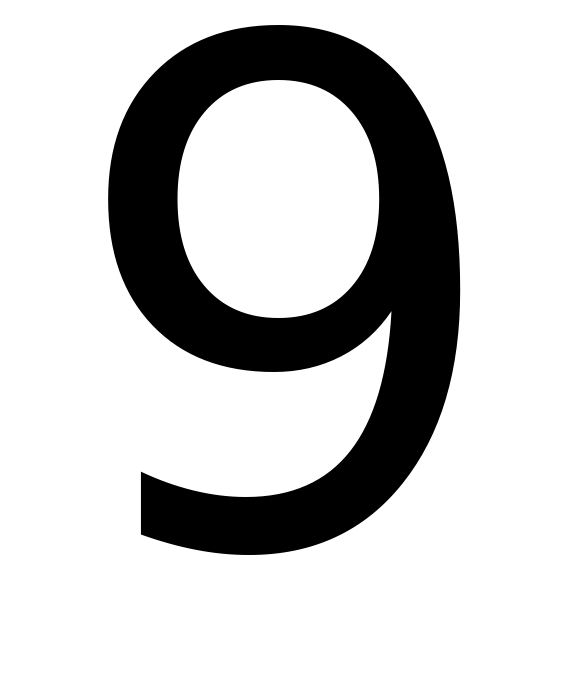

In [6]:
ideal_digits = np.zeros((10,28,28)) # Initializing array for the output

for digit in range(10): # Looping over the digits 0 through 9
    
    # Initializing figure, axis, and canvas objects
    fig = plt.figure(figsize=(10,10))
    ax = fig.gca()
    canvas = FigureCanvas(fig)

    # Placing the digit in the middle of the figure and removing the axis
    ax.text(0.5,0.5, str(digit), size=700, horizontalalignment='center', verticalalignment='center_baseline')
    ax.axis('off')

    # Drawing the figure
    canvas.draw()

    # Getting the width and height of the figure in pixels so that we know the correct size to make our image
    width, height = fig.get_size_inches() * fig.get_dpi()

    # Convert the matplotlib canvas information to a numpy array
    # Basically converting the figure to an image stored as an array
    image = np.frombuffer(canvas.tostring_rgb(), dtype='uint8').reshape(int(height), int(width), 3)
    
    # Converting the array to a PIL Image, resizing it to 28x28, converting it to grayscale, 
    # and then converting back to a NumPy array and putting it in our output array
    ideal_digits[digit,:,:] = np.array(Image.fromarray(image).resize((28,28)).convert('L'))
    
ideal_digits = 255 - ideal_digits # Switching black and white

(-0.5, 27.5, 27.5, -0.5)

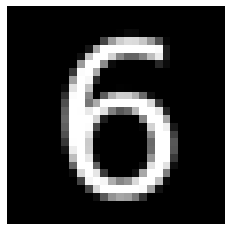

In [7]:
# Example perfect digit
plt.imshow(ideal_digits[6,:,:], cmap='gray')
plt.axis('off')

### Image Similarity Function
We have many choices for the function which we use to compare the similarity of images. In this case, we will use a simple method: imagine overlaying one image on top of the other, and if two pixels are both zero (black), or both not zero, increment the similarity score by 1. We can then use this to compare images we want to classify to our ideal images.

In [8]:
def compare_images(im1, im2, strict=False):
    '''
    Function for taking in two images and producing a "similarity score."
    The 'strict' argument, when True, requires exact equality between pixels for the similarity score to be incremented.
    '''
    if strict: # Count number of pixels **exactly** equal
        same_pixels = np.count_nonzero(im1 == im2) 
    else: # Count places where both images are nonzero or both exactly 0
        same_pixels = np.count_nonzero(np.multiply(im1, im2)) + np.count_nonzero(np.logical_and(im1 == 0, im2==0))
                
    return same_pixels

In [9]:
correct = 0
for image, label in zip(mnist_array, mnist.target): # Looping over images and actual labels
    scores = [compare_images(image, ideal) for ideal in ideal_digits] # Getting similarity scores with all the ideal digits
    prediction = np.argmax(scores) # Making a prediction according to the highest similarity score
    if prediction == int(label):
        correct += 1 # Incrementing the number of correct predictions if we got it right
print('Accuracy on 70000 images was:', 100 * correct/70000, 'percent')

Accuracy on 70000 images was: 32.83428571428571 percent
